In [1]:
import cv2
import keras
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
#from scipy.misc import imread
from imageio import imread
import os
import h5py

from ssd_model import SSD300
from ssd_utils import PriorUtil
from ssd_data import InputGenerator
from ssd_data import preprocess
from utils.model import load_weights

Using TensorFlow backend.


In [2]:
input_shape = (300, 300, 3)
batch_size = 32

voc_classes = ['Background', 'Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']


image_size = input_shape[:2]
from data_voc import GTUtility
gt_util = GTUtility('data/VOC2007/')
gt_util_train, gt_util_val = gt_util.split(gt_util, split=0.8)

In [3]:
model = SSD300(input_shape, num_classes=gt_util.num_classes)
prior_util = PriorUtil(model)
priors = prior_util.priors

In [4]:
weights_path = '~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
layer_list = [('block1_conv1', 'conv1_1'),
              ('block1_conv2', 'conv1_2'),
              ('block2_conv1', 'conv2_1'),
              ('block2_conv2', 'conv2_2'),
              ('block3_conv1', 'conv3_1'),
              ('block3_conv2', 'conv3_2'),
              ('block3_conv3', 'conv3_3'),
              ('block4_conv1', 'conv4_1'),
              ('block4_conv2', 'conv4_2'),
              ('block4_conv3', 'conv4_3'),
              ('block5_conv1', 'conv5_1'),
              ('block5_conv2', 'conv5_2'),
              ('block5_conv3', 'conv5_3')]
#load_weights(model, weights_path, layer_list)

#model.load_weights('./checkpoints/201708011145_ssd_voc/weights.174.h5', by_name=True)
#model.load_weights('./checkpoints/voc/weights.25-3.60.hdf5', by_name=True)
#model.load_weights('ssd300_voc_weights_fixed.hdf5', by_name=True)

weights_path = '~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
layer_list = [('block1_conv1', 'conv1_1'),
              ('block1_conv2', 'conv1_2'),
              ('block2_conv1', 'conv2_1'),
              ('block2_conv2', 'conv2_2'),
              ('block3_conv1', 'conv3_1'),
              ('block3_conv2', 'conv3_2'),
              ('block3_conv3', 'conv3_3'),
              ('block4_conv1', 'conv4_1'),
              ('block4_conv2', 'conv4_2'),
              ('block4_conv3', 'conv4_3'),
              ('block5_conv1', 'conv5_1'),
              ('block5_conv2', 'conv5_2'),
              ('block5_conv3', 'conv5_3'),
              ('fc1', 'fc6'),
              ('fc2', 'fc7')]

weights_path = os.path.expanduser(weights_path)
f = h5py.File(weights_path, 'r')

for name in layer_list:
    layer_name = name[1]
    name = name[0]
    layer = model.get_layer(layer_name)
    g = f[name]
    weights = [np.array(g[wn]) for wn in g.attrs['weight_names']]
    print(layer.name)
    for i in range(len(layer.weights)):
        w = layer.weights[i]
        wd = weights[i]
        print('%-20s %-20s %-20s' % (w.name, weights[i].shape, w.shape.as_list()))
    #layer.set_weights(weights)
f.close()

conv1_1
conv1_1/kernel:0     (3, 3, 3, 64)        [3, 3, 3, 64]       
conv1_1/bias:0       (64,)                [64]                
conv1_2
conv1_2/kernel:0     (3, 3, 64, 64)       [3, 3, 64, 64]      
conv1_2/bias:0       (64,)                [64]                
conv2_1
conv2_1/kernel:0     (3, 3, 64, 128)      [3, 3, 64, 128]     
conv2_1/bias:0       (128,)               [128]               
conv2_2
conv2_2/kernel:0     (3, 3, 128, 128)     [3, 3, 128, 128]    
conv2_2/bias:0       (128,)               [128]               
conv3_1
conv3_1/kernel:0     (3, 3, 128, 256)     [3, 3, 128, 256]    
conv3_1/bias:0       (256,)               [256]               
conv3_2
conv3_2/kernel:0     (3, 3, 256, 256)     [3, 3, 256, 256]    
conv3_2/bias:0       (256,)               [256]               
conv3_3
conv3_3/kernel:0     (3, 3, 256, 256)     [3, 3, 256, 256]    
conv3_3/bias:0       (256,)               [256]               
conv4_1
conv4_1/kernel:0     (3, 3, 256, 512)     [3, 3, 256, 

In [5]:
w_fc = np.load('vgg_reduced_fc.npy')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [10]:
w = model.weights[4]
w.shape.as_list()
w.name

'conv4_3/kernel:0'

In [7]:
l = model.layers[4]
w = l.weights[0]
w.shape.as_list()

[3, 3, 64, 128]

In [11]:
freeze = ['conv1_1', 'conv1_2',
          'conv2_1', 'conv2_2',
          'conv3_1', 'conv3_2', 'conv3_3',
          #'conv4_1', 'conv4_2', 'conv4_3',
          #'conv5_1', 'conv5_2', 'conv5_3',
         ]

for layer in model.layers:
    layer.trainable = not layer.name in freeze

In [12]:
model.load_weights('./models/ssd300_voc_weights_fixed.hdf5', by_name=True)

### shapes

In [15]:
from utils.caffe2keras import compare_output_shape
compare_output_shape(model, './models/ssd300_voc_shape.pkl')

conv1_1                        [64, 300, 300]       [300, 300, 64]       
conv1_2                        [64, 300, 300]       [300, 300, 64]       
pool1                          [64, 150, 150]       [150, 150, 64]       
conv2_1                        [128, 150, 150]      [150, 150, 128]      
conv2_2                        [128, 150, 150]      [150, 150, 128]      
pool2                          [128, 75, 75]        [75, 75, 128]        
conv3_1                        [256, 75, 75]        [75, 75, 256]        
conv3_2                        [256, 75, 75]        [75, 75, 256]        
conv3_3                        [256, 75, 75]        [75, 75, 256]        
pool3                          [256, 38, 38]        [38, 38, 256]        
conv4_1                        [512, 38, 38]        [38, 38, 512]        
conv4_2                        [512, 38, 38]        [38, 38, 512]        
conv4_3                        [512, 38, 38]        [38, 38, 512]        
pool4                          [512, 1

In [13]:
from utils.caffe2keras import compare_weights_shape
#compare_weights_shape(model, 'ssd300_voc_shape.pkl')

### preprocessing

In [14]:
from ssd_data import preprocess_image

np.set_printoptions(precision=10, linewidth=130, suppress=True)

img_path = './data/images/fish-bike.jpg'
img = preprocess_image(img_path, size=image_size, lib='skimage')

print(img.transpose((2, 0, 1))[:,:5,:5])

[[[-22.69574     -17.98938     -10.883713    -21.097084    -11.40815    ]
  [ -5.202896     -7.5436935     7.904457     -7.61792     -10.565018   ]
  [ -0.017959595   3.827835     21.810905     14.148605     -4.133919   ]
  [ 29.64         34.182953     33.38861      38.32965      20.931015   ]
  [ 40.08278      42.427795     34.917053     44.693527     46.11183    ]]

 [[-30.69574     -25.98938     -18.845383    -29.097084    -19.40815    ]
  [-13.398209    -15.658699      0.7329178   -15.61792     -18.565018   ]
  [ -9.716293     -5.172165     13.51091       6.3402634   -11.805206   ]
  [ 20.129059     25.425797     26.02887      31.627945     15.1826935  ]
  [ 31.53186      34.710587     28.262054     39.456665     41.678482   ]]

 [[-38.580734    -33.874382    -26.807053    -37.058746    -26.68222    ]
  [-17.69728     -20.1987       -5.6940002   -22.183601    -25.33503    ]
  [ -7.4712906    -5.022171     12.26091       3.8835983   -16.312622   ]
  [ 28.540237     31.575592     29

In [15]:
inputs = []
images = []
for img_path in ['./data/images/fish-bike.jpg',
                 './data/images/cat.jpg',
                 './data/images/boys.jpg',
                 './data/images/car_cat.jpg',
                 './data/images/car_cat2.jpg',
                ]:
    images.append(imread(img_path))
    input_image = preprocess_image(img_path, size=image_size, lib='skimage')
    inputs.append(input_image)

inputs = np.array(inputs)

### model output

In [21]:
preds = model.predict(inputs, batch_size=1, verbose=1)

results = [prior_util.decode(p, confidence_threshold=0.1) for p in preds]

5/5 [==============================] - 0s 12ms/step


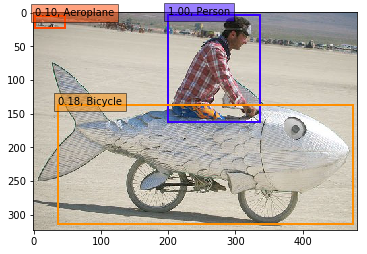

[[ 0.4157962185  0.0107474527  0.6993477309  0.503131606   0.9999206066 15.          ]
 [ 0.0741041999  0.4223928914  0.9860058867  0.971092706   0.1758668125  2.          ]
 [ 0.0029863237  0.0160644011  0.0986781779  0.07140763    0.1019328907  1.          ]]


In [24]:
plt.figure()
plt.imshow(images[0])
res = prior_util.decode(preds[0], confidence_threshold=0.1)
prior_util.plot_results(res, classes=gt_util.classes)
plt.show()
print(res)

In [25]:
# output shape

import pickle
shape_file = 'ssd300_voc_shape.pkl'
with open(shape_file, 'rb') as f:
    shape = pickle.load(f)
    for k, v in shape['output_shape'].items():
        if k.startswith('mbox_'):
            print('%-36s %-20s' % (k,v))
print()
for i in model.get_layer(name='predictions').get_input_at(0):
    print('%-25s %s' % (i.name, str(i.shape)))

mbox_conf_softmax                    (1, 8732, 21)       
mbox_conf_flatten                    (1, 183372)         
mbox_conf_reshape                    (1, 8732, 21)       
mbox_priorbox                        (1, 2, 34928)       
mbox_loc                             (1, 34928)          
mbox_conf                            (1, 183372)         

mbox_loc_final/Reshape:0  (?, ?, 4)
mbox_conf_final/truediv:0 (?, ?, 21)


In [30]:
# decompose network output

np.set_printoptions(precision=6, linewidth=100, suppress=True)

p = preds[0] # first image
print(p.shape)
print('location', p[0,:4])
print('classes', p[0,4:25])
#print(p[:,25:])

(8732, 25)
location [ 1.039652  1.959443 -4.791593 -4.198446]
classes [0.967713 0.006406 0.000671 0.002122 0.001996 0.001133 0.001179 0.005525 0.000246 0.000999 0.000606
 0.000482 0.000355 0.000442 0.000462 0.006809 0.000408 0.001059 0.000347 0.000469 0.00057 ]


### general model info

In [ ]:
#model.summary()

In [ ]:
import pydot
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

file_name = 'ssd300.dot'
dot = model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='dot')
f = open(file_name, 'w+b')
f.write(dot)
f.close()

graph = pydot.graph_from_dot_file(file_name)
graph.write_png('somefile.png')
#Image(graph.create_png(prog='dot')) # {‘dot’: ‘’, ‘twopi’: ‘’, ‘neato’: ‘’, ‘circo’: ‘’, ‘fdp’: ‘’}

### prior boxes

In [ ]:
fstr = '%-28s %-20s %-20s %-12s %-9s %-9s %-28s %-22s %-8s %-8s %-8s'
print(fstr % ('', 'input_shape', 'output_shape', 'img_size', 'min_size', 'max_size', 'aspect_ratios', 'variances', 'clip', 'flip', 'step'))
for l in model.layers:
    if l.__class__.__name__ == 'PriorBox':
        aspect_ratios = [ round(r, 2) for r in l.aspect_ratios ]
        print(fstr % (l.name, l.input_shape, l.output_shape, l.img_size, l.min_size, l.max_size, aspect_ratios, l.variances, l.clip, l.flip, l.step))

In [ ]:
from utils.vis import plot_priorboxes
from ssd_utils import calc_priorboxes
        
img_path = 'pics/fish-bike.jpg'
image = imread(img_path)
input_image = preprocess_image(img_path)

for layer in model.layers:
    if layer.__class__.__name__ == 'PriorBox':
        prior_boxes = calc_priorboxes(model, layer.name)
        nratios = len(layer.aspect_ratios)
        nlocs = len(prior_boxes)/nratios
        print('%-28s  locations: %-6i  aspect_ratios: %s' % (layer.name, nlocs, layer.aspect_ratios))
        #plot_priorboxes(prior_boxes, image, nratios)

#np.save('ssd300_prior_boxes.npy', calc_priorboxes(model))
#pb = np.load('ssd300_prior_boxes.npy')

In [ ]:
# compare the prior boxes

mbox_priorbox = model.get_layer('mbox_priorbox')
f = K.function(model.inputs, [mbox_priorbox.output])
pb_keras = f([[input_image]])[0][0][:,:4]

pb_caffe = np.load('ssd300_prior_boxes_caffe.npy')

print(pb_keras[:10])
print(np.array([np.min(pb_keras, 0), np.max(pb_keras, 0), np.mean(pb_keras, 0)]))
print()
print(pb_caffe[:10])
print(np.array([np.min(pb_caffe, 0), np.max(pb_caffe, 0), np.mean(pb_caffe, 0)]))
print()
pb_diff = pb_keras - pb_caffe
print(pb_diff[:10])
print(np.mean(pb_diff, 0))
print(np.nonzero(np.round(pb_diff, 6))[0])

In [ ]:
# compare the locations

pos_keras = np.array([pb_keras[:,0]+pb_keras[:,2], pb_keras[:,1]+pb_keras[:,3]]).T/2
pos_caffe = np.array([pb_caffe[:,0]+pb_caffe[:,2], pb_caffe[:,1]+pb_caffe[:,3]]).T/2
pos_diff = pos_keras - pos_caffe

print(np.array([np.min(pos_keras, 0), np.max(pos_keras, 0), np.mean(pos_keras, 0)]))
print()
print(np.array([np.min(pos_caffe, 0), np.max(pos_caffe, 0), np.mean(pos_caffe, 0)]))
print()
print(pos_diff[:20])
print(np.nonzero(np.round(pos_diff, 6))[0])

In [ ]:
# computation of prior box locations

steps = [8, 16, 32, 64, 100, 300]
img_width, img_height = 300, 300
layer_sizes = (38, 19, 10, 5, 3, 1)
aspect_ratios = ([1.0, 1.0, 2, 0.5], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5], [1.0, 1.0, 2, 0.5])

idx = 0
for i in range(len(layer_sizes)):
    nboxes = len(aspect_ratios[i]) * layer_sizes[i]**2
    print("%i  %s  %i" % (layer_sizes[i], aspect_ratios[i], nboxes))
    print(np.max(pos_keras[idx:idx+nboxes,0]))
    print(np.max(pos_caffe[idx:idx+nboxes,0]))
    #print(np.min(pos_keras[idx:idx+nboxes,0]))
    #print(np.min(pos_caffe[idx:idx+nboxes,0]))
    
    layer_width = layer_sizes[i]
    
    # keras way
    step_x = img_width / layer_width
    centers_x = np.linspace(step_x / 2., img_width - step_x / 2., layer_width) / img_width
    #centers_x = np.array([(0.5 + i) for i in range(layer_width)]) * step_x / img_width
    print('%-20s %-20s' % (np.max(centers_x), step_x))
    
    # caffe way
    step_x = steps[i]
    centers_x = np.array([(0.5 + i) for i in range(layer_width)]) * step_x / img_width
    print('%-20s %-20s' % (np.max(centers_x), step_x))
    
    print()
    idx += nboxes

### layer activation

In [ ]:
po = np.get_printoptions()
#np.set_printoptions(formatter={'all': '{:+.6e}'.format})
np.set_printoptions(formatter={'all': '{:+.8f}'.format})

print('%-28s %14s %10s %10s  %4s' % ('', 'max activation', 'mean diff', 'max diff', 'ratio'))

for layer in model.layers:
    layer_name = layer.name
    
    file_name = os.path.join('./caffe_activation_dumps/ssd300_voc_activations_fish-bike', layer_name+'.npy')
    try:
        caffe_output = np.load(file_name)
    except FileNotFoundError:
        print(layer_name)
        continue
        
    if len(caffe_output.shape) == 4:
        caffe_output = caffe_output.transpose(0,2,3,1)

    input_image = preprocess_image('./data/images/fish-bike.jpg', input_shape[:2])
    f = K.function(model.inputs, [model.get_layer(layer_name).output])
    keras_output = f([[input_image]])[0]
    
    #import keras.applications.imagenet_utils
    #import keras.preprocessing.image
    #input_image = keras.preprocessing.image.load_img(img_path, target_size=image_size)
    #input_image = keras.preprocessing.image.img_to_array(input_image)
    #input_image = input_image.transpose((1,0,2))
    #input_image = input_image[:, :, (0,2,1)]
    #input_image = input_image[:, :, (0,1,2)]
    #input_image = input_image[:, :, (1,0,2)]
    #input_image = input_image[:, :, (1,2,0)]
    #input_image = input_image[:, :, (2,0,1)]
    #input_image = input_image[:, :, (2,1,0)]
    #input_images = keras.applications.imagenet_utils.preprocess_input(np.array([input_image]))
    #f = K.function(model.inputs, [model.get_layer(layer_name).output])
    #keras_output = f([input_images])[0]

    try:
        diff = np.round(caffe_output[0]-keras_output[0], 9)
    except ValueError:
        print(layer_name)
        continue
    
    max_value = np.max(keras_output)
    min_diff = np.abs(np.min(diff))
    max_diff = np.abs(np.max(diff))
    mean_diff = np.abs(np.mean(diff))
    
    diff_ratio = np.nonzero(np.round(diff,5))[0].shape[0] / np.prod(diff.shape)
    
    print('%-28s %14.6f %10.6f %10.6f  %3i%%' % (layer_name, max_value, mean_diff, max_diff, diff_ratio*100))
    
    n = 12; p = 5
    #print(np.round( diff[:n,:n,p], 8))

np.set_printoptions(po)

### visualization

In [ ]:
from utils.vis import plot_activation, mosaic

for name in ['conv1_2', 'conv2_2', 'conv3_3', 'conv4_3', 'conv5_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2']:
    #plot_activation(model, inputs[3], name)
    pass

In [ ]:
l = model.get_layer('conv8_2')
W = l.get_weights()[0]
W = W.transpose(2,3,0,1)

print(W.shape)
from matplotlib import cm
plt.figure(figsize=(15, 15))
#pl.title('conv1 weights')
plt.imshow(mosaic(W[0], (6, 6)), cmap=cm.binary)
plt.show()
# may be wrong, dimensions...

In [ ]:
for name in ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2']:
    print(name)
    layer = model.get_layer(name)
    weights = layer.get_weights()
    new_weights = []
    for w in weights:
        new_weights.append(np.random.randn(*w.shape))
    layer.set_weights(new_weights)
    
    weights = layer.get_weights()
    #print(type(weights))
    #print(len(weights))
    print(weights[0].shape)
    #print(np.max(weights[0]))
    print(weights[0][1][1][:,:])
    #print(new_weights[0][1][1][:,:])

In [ ]:
layer = model.get_layer('conv2_2')
old_w = layer.get_weights()
new_w = [np.random.randn(3,3,128,128),np.random.randn(128)]
layer.set_weights(new_w)
updated_w = layer.get_weights()
#print([w.shape for w in old_w])
#print(old_w[0][1][1][:,:])
#print([w.shape for w in new_w])
print(new_w[0][1][1][:,:])
#print([w.shape for w in updated_w])
print(updated_w[0][1][1][:,:])

In [ ]:
layer.set_weights([np.random.randn(3,3,128,128),np.random.randn(128)])
layer.get_weights()

In [ ]:
for name in ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2']:
    layer = model.get_layer(name)
    weights = layer.get_weights()
    print(weights[0][1][1][10:20,10:20])